<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/swinir_with_cropped_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media


Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.3 MB/s eta 0:00:00


In [2]:
# Download SwinIR pretrained models
!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/trappertwo/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg20.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg30.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth -P experiments/pretrained_models

rm: cannot remove 'SwinIR': No such file or directory
Cloning into 'SwinIR'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 339 (delta 9), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (339/339), 31.72 MiB | 27.13 MiB/s, done.
Resolving deltas: 100% (122/122), done.
--2025-10-27 15:14:21--  https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/396770997/2c43e270-4a3e-4893-8920-1dc0550fec2f?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-27T16%3A14%3A39Z&rscd=attachment%3B+filename%3D006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth&rsct=application%2Foctet-stream&s

In [3]:
# Download the Swin2SR pretrained model
!wget https://github.com/mv-lab/swin2sr/releases/tag/v0.0.1/Swin2SR_Jpeg_dynamic.pth -P experiments/pretrained_models

--2025-10-27 15:14:34--  https://github.com/mv-lab/swin2sr/releases/tag/v0.0.1/Swin2SR_Jpeg_dynamic.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘experiments/pretrained_models/Swin2SR_Jpeg_dynamic.pth’

Swin2SR_Jpeg_dynami     [ <=>                ] 190.33K  --.-KB/s    in 0.02s   

2025-10-27 15:14:34 (7.62 MB/s) - ‘experiments/pretrained_models/Swin2SR_Jpeg_dynamic.pth’ saved [194895]



In [4]:
## Preprocessing - face detection
import cv2
import datetime
import math
from cv2 import dnn_superres


def read_video(video_file):
    """Reads a video file, returns frames(T, H, W, 3) """
    VidObj = cv2.VideoCapture(video_file)
    VidObj.set(cv2.CAP_PROP_POS_MSEC, 0)
    success, frame = VidObj.read()
    frames = list()
    while success:
      frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
      frame = np.asarray(frame)
      frames.append(frame)
      success, frame = VidObj.read()
    return np.asarray(frames)

def read_wave(bvp_file):
        """Reads a bvp signal file."""
        with open(bvp_file, "r") as f:
            str1 = f.read()
            str1 = str1.split("\n")
            bvp = [float(x) for x in str1[0].split()]
        return np.asarray(bvp)

def face_detection(frame, backend, use_larger_box=False, larger_box_coef=1.0):
        """Face detection on a single frame.

        Args:
            frame(np.array): a single frame.
            backend(str): backend to utilize for face detection.
            use_larger_box(bool): whether to use a larger bounding box on face detection.
            larger_box_coef(float): Coef. of larger box.
        Returns:
            face_box_coor(List[int]): coordinates of face bouding box.
        """
        if backend == "HC":
            # Use OpenCV's Haar Cascade algorithm implementation for face detection
            # This should only utilize the CPU
            detector = cv2.CascadeClassifier(
            '/content/drive/MyDrive/DATASETS/haarcascade_frontalface_default.xml')

            # Computed face_zone(s) are in the form [x_coord, y_coord, width, height]
            # (x,y) corresponds to the top-left corner of the zone to define using
            # the computed width and height.
            face_zone = detector.detectMultiScale(frame)

            if len(face_zone) < 1:
                print("ERROR: No Face Detected")
                face_box_coor = [0, 0, frame.shape[0], frame.shape[1]]
            elif len(face_zone) >= 2:
                # Find the index of the largest face zone
                # The face zones are boxes, so the width and height are the same
                max_width_index = np.argmax(face_zone[:, 2])  # Index of maximum width
                face_box_coor = face_zone[max_width_index]
                print("Warning: More than one faces are detected. Only cropping the biggest one.")
            else:
                face_box_coor = face_zone[0]
        else:
            raise ValueError("Unsupported face detection backend!")

        if use_larger_box:
            face_box_coor[0] = max(0, face_box_coor[0] - (larger_box_coef - 1.0) / 2 * face_box_coor[2])
            face_box_coor[1] = max(0, face_box_coor[1] - (larger_box_coef - 1.0) / 2 * face_box_coor[3])
            face_box_coor[2] = larger_box_coef * face_box_coor[2]
            face_box_coor[3] = larger_box_coef * face_box_coor[3]
        return face_box_coor

In [5]:
import numpy as np
import os
import torch
import sys

# Face cropping
def crop_face_resize(frames, use_face_detection,  use_larger_box, larger_box_coef, use_dynamic_detection,
                         detection_freq, use_median_box, width, height):
  """Crop face and resize frames.

     Args:
       frames(np.array): Video frames.
       use_face_detection(bool):  Whether crop the face.
       use_dynamic_detection(bool): If False, all the frames use the first frame's bouding box to crop the faces
                                         and resizing.
                                         If True, it performs face detection every "detection_freq" frames.
       detection_freq(int): The frequency of dynamic face detection e.g., every detection_freq frames.
       width(int): Target width for resizing.
       height(int): Target height for resizing.
       use_larger_box(bool): Whether enlarge the detected bouding box from face detection.
       larger_box_coef(float): the coefficient of the larger region(height and weight)
                             the middle point of the detected region will stay still during the process of enlarging.
     Returns:
       resized_frames(list[np.array(float)]): Resized and cropped frames
  """
  # Face Cropping
  if use_dynamic_detection:
    num_dynamic_det = math.ceil(frames.shape[0] / detection_freq)
  else:
    num_dynamic_det = 1
  face_region_all = []
  # Perform face detection by num_dynamic_det" times.
  for idx in range(num_dynamic_det):
    if use_face_detection:
       face_region_all.append(face_detection(frames[detection_freq * idx], "HC", use_larger_box, larger_box_coef))
    else:
       face_region_all.append([0, 0, frames.shape[1], frames.shape[2]])
  if use_median_box:
     # Generate a median bounding box based on all detected face regions
     face_region_median = np.median(np.asarray(face_region_all, dtype='int'), axis=0).astype('int')
  print(np.asarray(face_region_all, dtype='int'))

  # Frame Resizing
  resized_frames = []
  for i in range(0, frames.shape[0]):
    frame = frames[i]
    if use_dynamic_detection:  # use the (i // detection_freq)-th facial region.
      reference_index = i // detection_freq
    else:  # use the first region obtrained from the first frame.
      reference_index = 0
    if use_face_detection:
      if use_median_box:
         face_region = face_region_median
      else:
         face_region = np.asarray(face_region_all, dtype='int')[reference_index]
      frame = frame[max(face_region[1], 0):min(face_region[1] + face_region[3], frame.shape[0]),
         max(face_region[0], 0):min(face_region[0] + face_region[2], frame.shape[1])]

    # Resize the frame
    resized_frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
    resized_frames.append(resized_frame)

  #return np.array(resized_frames)
  return resized_frames



def frames_to_video(frames, output_path, fps=30):
    """Converts a sequence of frames to an MPEG4 video.

    Args:
        frames: A list of frames (numpy arrays) to be converted to a video.
        output_path: Name of the output video file (e.g., 'output.mp4').
        fps: Frames per second for the output video.
    """

    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MPEG-4
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      video_writer.write(frame_rgb)

    video_writer.release()

# **Inference**

In [6]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive
import os

SUBJECT = 'subject9' # @param {type : "string"}

drive.mount('/content/drive')
#filepath = '/content/drive/MyDrive/research_project/'
DIR_PATH = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_uncompressed_test' # @param {type: "string"}
filepath = os.path.join(DIR_PATH, SUBJECT)
video_path = os.path.join(filepath, 'vid.mp4')
bvp_path = os.path.join(filepath, 'ground_truth.txt')

!ls -l $filepath

Mounted at /content/drive
total 268489
-rw------- 1 root root     96774 Mar 11  2025 ground_truth.txt
-rw------- 1 root root 274835042 Mar 11  2025 vid.mp4


In [7]:
video = media.read_video(video_path)
bvp = read_wave(bvp_path)
videos = {'Original': video[:10]}
media.show_videos(videos, fps=30)

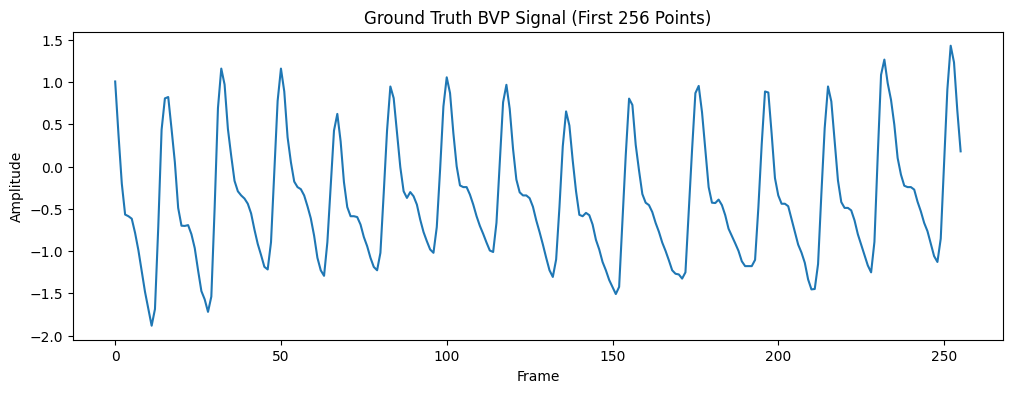

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(bvp[:256])
plt.title('Ground Truth BVP Signal (First 256 Points)')
plt.xlabel('Frame')
plt.ylabel('Amplitude')
plt.show()

In [9]:
# Compress the video with default settings (H.264 codec)
BIT_RATE = "500_000" # @param {type: "string"}

COMPRESSION_BIT_RATES = {BIT_RATE}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))
# Save the compressed video to a file
with open('/tmp/subject1_{BIT_RATE}.mp4', 'wb') as f:
    f.write(compressed_data[BIT_RATE])
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_{BIT_RATE}.mp4')
videos = {'Original': video[:10],  'Compressed_{BIT_RATE}': compressed_video[:10]}
media.show_videos(videos, fps=30)

4222942


2016



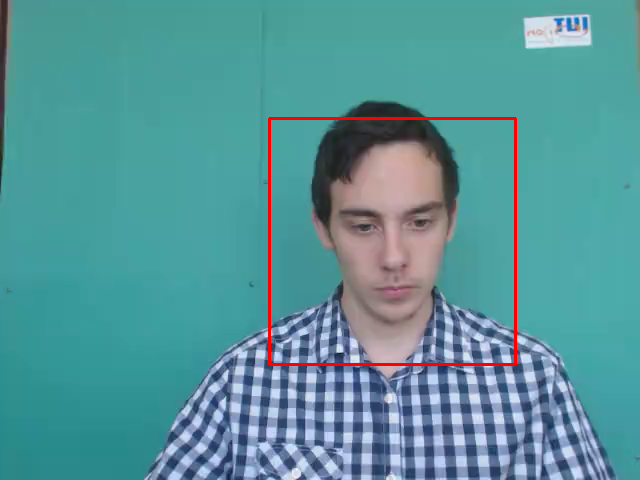

In [10]:
# Check face detection on one frame
print(len(compressed_video))
face_box_coor = face_detection(compressed_video[1], backend='HC', use_larger_box=True, larger_box_coef=1.5)
new_frame = cv2.rectangle(compressed_video[0], (face_box_coor[0], face_box_coor[1]), (face_box_coor[0] + face_box_coor[2], face_box_coor[1] + face_box_coor[3]), (255, 0, 0), 2)
media.show_image(new_frame)

In [11]:
# Clone the repository from github if not already setup
import os

dir_path = '/content/rPPG-Toolbox'
if os.path.isdir(dir_path):
  print(f"The directory '{dir_path}' exists.")
else:
  !git clone --branch rPPG_compressed https://github.com/trappertwo/rPPG-Toolbox.git
!ls -l '{dir_path}'

Cloning into 'rPPG-Toolbox'...
remote: Enumerating objects: 3927, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 3927 (delta 134), reused 107 (delta 107), pack-reused 3783 (from 3)
Receiving objects: 100% (3927/3927), 333.79 MiB | 39.58 MiB/s, done.
Resolving deltas: 100% (2678/2678), done.
Updating files: 100% (293/293), done.
total 192
-rw-r--r-- 1 root root 31506 Oct 27 15:15  config.py
drwxr-xr-x 4 root root  4096 Oct 27 15:15  configs
drwxr-xr-x 4 root root  4096 Oct 27 15:15  dataset
drwxr-xr-x 2 root root  4096 Oct 27 15:15  evaluation
drwxr-xr-x 2 root root  4096 Oct 27 15:15  figures
drwxr-xr-x 2 root root  4096 Oct 27 15:15  final_model_release
-rw-r--r-- 1 root root  8886 Oct 27 15:15  LICENSE
-rw-r--r-- 1 root root 15237 Oct 27 15:15  main.py
drwxr-xr-x 2 root root  4096 Oct 27 15:15  model_outputs
drwxr-xr-x 5 root root  4096 Oct 27 15:15  neural_methods
-rw-r--r-- 1 root root 33105 Oct 27 15:15  README.

In [16]:
# Add the SwinIR directory to the system path
sys.path.append('SwinIR')
sys.path.append('rPPG-Toolbox')

from models.network_swinir import SwinIR as net
from torch.utils.data import TensorDataset
from neural_methods.model.PhysNet import PhysNet_padding_Encoder_Decoder_MAX

def load_swinir_model(model_path, window_size=7, img_size=126, model_type='jpeg_car'):
    """Loads the pretrained SwinIR model"""

    print(f"Model type: {model_type}")
    # set up model
    if os.path.exists(model_path):
        print(f'loading model from {model_path}')
    else:
        raise ValueError(f'model {model_path} does not exist.')
    if model_type == 'jpeg_car':
        model = net(upscale=1, in_chans=3, img_size=img_size, window_size=window_size,
                    img_range=255., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
                    mlp_ratio=2, upsampler='', resi_connection='1conv')
    elif model_type == 'color_dn':
        model = net(upscale=1, in_chans=3, img_size=128, window_size=8,
                    img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
                    mlp_ratio=2, upsampler='', resi_connection='1conv')
    elif model_type == 'lightweight_sr':
        model = net(upscale=1, in_chans=3, img_size=64, window_size=8,
                    img_range=1., depths=[6, 6, 6, 6], embed_dim=60, num_heads=[6, 6, 6, 6],
                    mlp_ratio=2, upsampler='pixelshuffledirect', resi_connection='1conv')
    else:
        print(f"Invalid model_type {model_type}")
    param_key_g = 'params'
    pretrained_model = torch.load(model_path)
    model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)

    return model

def load_physnet_model(model_path, num_frames):
  # set up model
  if os.path.exists(model_path):
    print(f'loading model from {model_path}')
  else:
    raise ValueError(f'model {model_path} does not exist.')
  model = PhysNet_padding_Encoder_Decoder_MAX(frames=num_frames)
  model.load_state_dict(torch.load(model_path))
  print("Testing uses Physnet pretrained model!")
  return model

In [15]:
# Load SwinIR model
MODEL_PATH_40 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth' # @param {type: "string"}
MODEL_PATH_30 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg30.pth' # @param {type: "string"}
MODEL_PATH_20 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg20.pth' # @param {type: "string"}
MODEL_PATH_10 = 'experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth' # @param {type: "string"}
LIGHTWEIGHT_SR = '/content/drive/MyDrive/research_project//experiments/pretrained_models/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x2.pth' # @param {type: "string"}
restoration_model = load_swinir_model(LIGHTWEIGHT_SR)
print(restoration_model)

loading model from /content/drive/MyDrive/research_project//experiments/pretrained_models/002_lightweightSR_DIV2K_s64w8_SwinIR-S_x2.pth


RuntimeError: Error(s) in loading state_dict for SwinIR:
	Missing key(s) in state_dict: "layers.4.residual_group.blocks.0.norm1.weight", "layers.4.residual_group.blocks.0.norm1.bias", "layers.4.residual_group.blocks.0.attn.relative_position_bias_table", "layers.4.residual_group.blocks.0.attn.relative_position_index", "layers.4.residual_group.blocks.0.attn.qkv.weight", "layers.4.residual_group.blocks.0.attn.qkv.bias", "layers.4.residual_group.blocks.0.attn.proj.weight", "layers.4.residual_group.blocks.0.attn.proj.bias", "layers.4.residual_group.blocks.0.norm2.weight", "layers.4.residual_group.blocks.0.norm2.bias", "layers.4.residual_group.blocks.0.mlp.fc1.weight", "layers.4.residual_group.blocks.0.mlp.fc1.bias", "layers.4.residual_group.blocks.0.mlp.fc2.weight", "layers.4.residual_group.blocks.0.mlp.fc2.bias", "layers.4.residual_group.blocks.1.attn_mask", "layers.4.residual_group.blocks.1.norm1.weight", "layers.4.residual_group.blocks.1.norm1.bias", "layers.4.residual_group.blocks.1.attn.relative_position_bias_table", "layers.4.residual_group.blocks.1.attn.relative_position_index", "layers.4.residual_group.blocks.1.attn.qkv.weight", "layers.4.residual_group.blocks.1.attn.qkv.bias", "layers.4.residual_group.blocks.1.attn.proj.weight", "layers.4.residual_group.blocks.1.attn.proj.bias", "layers.4.residual_group.blocks.1.norm2.weight", "layers.4.residual_group.blocks.1.norm2.bias", "layers.4.residual_group.blocks.1.mlp.fc1.weight", "layers.4.residual_group.blocks.1.mlp.fc1.bias", "layers.4.residual_group.blocks.1.mlp.fc2.weight", "layers.4.residual_group.blocks.1.mlp.fc2.bias", "layers.4.residual_group.blocks.2.norm1.weight", "layers.4.residual_group.blocks.2.norm1.bias", "layers.4.residual_group.blocks.2.attn.relative_position_bias_table", "layers.4.residual_group.blocks.2.attn.relative_position_index", "layers.4.residual_group.blocks.2.attn.qkv.weight", "layers.4.residual_group.blocks.2.attn.qkv.bias", "layers.4.residual_group.blocks.2.attn.proj.weight", "layers.4.residual_group.blocks.2.attn.proj.bias", "layers.4.residual_group.blocks.2.norm2.weight", "layers.4.residual_group.blocks.2.norm2.bias", "layers.4.residual_group.blocks.2.mlp.fc1.weight", "layers.4.residual_group.blocks.2.mlp.fc1.bias", "layers.4.residual_group.blocks.2.mlp.fc2.weight", "layers.4.residual_group.blocks.2.mlp.fc2.bias", "layers.4.residual_group.blocks.3.attn_mask", "layers.4.residual_group.blocks.3.norm1.weight", "layers.4.residual_group.blocks.3.norm1.bias", "layers.4.residual_group.blocks.3.attn.relative_position_bias_table", "layers.4.residual_group.blocks.3.attn.relative_position_index", "layers.4.residual_group.blocks.3.attn.qkv.weight", "layers.4.residual_group.blocks.3.attn.qkv.bias", "layers.4.residual_group.blocks.3.attn.proj.weight", "layers.4.residual_group.blocks.3.attn.proj.bias", "layers.4.residual_group.blocks.3.norm2.weight", "layers.4.residual_group.blocks.3.norm2.bias", "layers.4.residual_group.blocks.3.mlp.fc1.weight", "layers.4.residual_group.blocks.3.mlp.fc1.bias", "layers.4.residual_group.blocks.3.mlp.fc2.weight", "layers.4.residual_group.blocks.3.mlp.fc2.bias", "layers.4.residual_group.blocks.4.norm1.weight", "layers.4.residual_group.blocks.4.norm1.bias", "layers.4.residual_group.blocks.4.attn.relative_position_bias_table", "layers.4.residual_group.blocks.4.attn.relative_position_index", "layers.4.residual_group.blocks.4.attn.qkv.weight", "layers.4.residual_group.blocks.4.attn.qkv.bias", "layers.4.residual_group.blocks.4.attn.proj.weight", "layers.4.residual_group.blocks.4.attn.proj.bias", "layers.4.residual_group.blocks.4.norm2.weight", "layers.4.residual_group.blocks.4.norm2.bias", "layers.4.residual_group.blocks.4.mlp.fc1.weight", "layers.4.residual_group.blocks.4.mlp.fc1.bias", "layers.4.residual_group.blocks.4.mlp.fc2.weight", "layers.4.residual_group.blocks.4.mlp.fc2.bias", "layers.4.residual_group.blocks.5.attn_mask", "layers.4.residual_group.blocks.5.norm1.weight", "layers.4.residual_group.blocks.5.norm1.bias", "layers.4.residual_group.blocks.5.attn.relative_position_bias_table", "layers.4.residual_group.blocks.5.attn.relative_position_index", "layers.4.residual_group.blocks.5.attn.qkv.weight", "layers.4.residual_group.blocks.5.attn.qkv.bias", "layers.4.residual_group.blocks.5.attn.proj.weight", "layers.4.residual_group.blocks.5.attn.proj.bias", "layers.4.residual_group.blocks.5.norm2.weight", "layers.4.residual_group.blocks.5.norm2.bias", "layers.4.residual_group.blocks.5.mlp.fc1.weight", "layers.4.residual_group.blocks.5.mlp.fc1.bias", "layers.4.residual_group.blocks.5.mlp.fc2.weight", "layers.4.residual_group.blocks.5.mlp.fc2.bias", "layers.4.conv.weight", "layers.4.conv.bias", "layers.5.residual_group.blocks.0.norm1.weight", "layers.5.residual_group.blocks.0.norm1.bias", "layers.5.residual_group.blocks.0.attn.relative_position_bias_table", "layers.5.residual_group.blocks.0.attn.relative_position_index", "layers.5.residual_group.blocks.0.attn.qkv.weight", "layers.5.residual_group.blocks.0.attn.qkv.bias", "layers.5.residual_group.blocks.0.attn.proj.weight", "layers.5.residual_group.blocks.0.attn.proj.bias", "layers.5.residual_group.blocks.0.norm2.weight", "layers.5.residual_group.blocks.0.norm2.bias", "layers.5.residual_group.blocks.0.mlp.fc1.weight", "layers.5.residual_group.blocks.0.mlp.fc1.bias", "layers.5.residual_group.blocks.0.mlp.fc2.weight", "layers.5.residual_group.blocks.0.mlp.fc2.bias", "layers.5.residual_group.blocks.1.attn_mask", "layers.5.residual_group.blocks.1.norm1.weight", "layers.5.residual_group.blocks.1.norm1.bias", "layers.5.residual_group.blocks.1.attn.relative_position_bias_table", "layers.5.residual_group.blocks.1.attn.relative_position_index", "layers.5.residual_group.blocks.1.attn.qkv.weight", "layers.5.residual_group.blocks.1.attn.qkv.bias", "layers.5.residual_group.blocks.1.attn.proj.weight", "layers.5.residual_group.blocks.1.attn.proj.bias", "layers.5.residual_group.blocks.1.norm2.weight", "layers.5.residual_group.blocks.1.norm2.bias", "layers.5.residual_group.blocks.1.mlp.fc1.weight", "layers.5.residual_group.blocks.1.mlp.fc1.bias", "layers.5.residual_group.blocks.1.mlp.fc2.weight", "layers.5.residual_group.blocks.1.mlp.fc2.bias", "layers.5.residual_group.blocks.2.norm1.weight", "layers.5.residual_group.blocks.2.norm1.bias", "layers.5.residual_group.blocks.2.attn.relative_position_bias_table", "layers.5.residual_group.blocks.2.attn.relative_position_index", "layers.5.residual_group.blocks.2.attn.qkv.weight", "layers.5.residual_group.blocks.2.attn.qkv.bias", "layers.5.residual_group.blocks.2.attn.proj.weight", "layers.5.residual_group.blocks.2.attn.proj.bias", "layers.5.residual_group.blocks.2.norm2.weight", "layers.5.residual_group.blocks.2.norm2.bias", "layers.5.residual_group.blocks.2.mlp.fc1.weight", "layers.5.residual_group.blocks.2.mlp.fc1.bias", "layers.5.residual_group.blocks.2.mlp.fc2.weight", "layers.5.residual_group.blocks.2.mlp.fc2.bias", "layers.5.residual_group.blocks.3.attn_mask", "layers.5.residual_group.blocks.3.norm1.weight", "layers.5.residual_group.blocks.3.norm1.bias", "layers.5.residual_group.blocks.3.attn.relative_position_bias_table", "layers.5.residual_group.blocks.3.attn.relative_position_index", "layers.5.residual_group.blocks.3.attn.qkv.weight", "layers.5.residual_group.blocks.3.attn.qkv.bias", "layers.5.residual_group.blocks.3.attn.proj.weight", "layers.5.residual_group.blocks.3.attn.proj.bias", "layers.5.residual_group.blocks.3.norm2.weight", "layers.5.residual_group.blocks.3.norm2.bias", "layers.5.residual_group.blocks.3.mlp.fc1.weight", "layers.5.residual_group.blocks.3.mlp.fc1.bias", "layers.5.residual_group.blocks.3.mlp.fc2.weight", "layers.5.residual_group.blocks.3.mlp.fc2.bias", "layers.5.residual_group.blocks.4.norm1.weight", "layers.5.residual_group.blocks.4.norm1.bias", "layers.5.residual_group.blocks.4.attn.relative_position_bias_table", "layers.5.residual_group.blocks.4.attn.relative_position_index", "layers.5.residual_group.blocks.4.attn.qkv.weight", "layers.5.residual_group.blocks.4.attn.qkv.bias", "layers.5.residual_group.blocks.4.attn.proj.weight", "layers.5.residual_group.blocks.4.attn.proj.bias", "layers.5.residual_group.blocks.4.norm2.weight", "layers.5.residual_group.blocks.4.norm2.bias", "layers.5.residual_group.blocks.4.mlp.fc1.weight", "layers.5.residual_group.blocks.4.mlp.fc1.bias", "layers.5.residual_group.blocks.4.mlp.fc2.weight", "layers.5.residual_group.blocks.4.mlp.fc2.bias", "layers.5.residual_group.blocks.5.attn_mask", "layers.5.residual_group.blocks.5.norm1.weight", "layers.5.residual_group.blocks.5.norm1.bias", "layers.5.residual_group.blocks.5.attn.relative_position_bias_table", "layers.5.residual_group.blocks.5.attn.relative_position_index", "layers.5.residual_group.blocks.5.attn.qkv.weight", "layers.5.residual_group.blocks.5.attn.qkv.bias", "layers.5.residual_group.blocks.5.attn.proj.weight", "layers.5.residual_group.blocks.5.attn.proj.bias", "layers.5.residual_group.blocks.5.norm2.weight", "layers.5.residual_group.blocks.5.norm2.bias", "layers.5.residual_group.blocks.5.mlp.fc1.weight", "layers.5.residual_group.blocks.5.mlp.fc1.bias", "layers.5.residual_group.blocks.5.mlp.fc2.weight", "layers.5.residual_group.blocks.5.mlp.fc2.bias", "layers.5.conv.weight", "layers.5.conv.bias", "conv_last.weight", "conv_last.bias". 
	Unexpected key(s) in state_dict: "upsample.0.weight", "upsample.0.bias". 
	size mismatch for conv_first.weight: copying a param with shape torch.Size([60, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([180, 3, 3, 3]).
	size mismatch for conv_first.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for patch_embed.norm.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for patch_embed.norm.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.0.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.0.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.0.residual_group.blocks.0.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.0.residual_group.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.0.residual_group.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.0.residual_group.blocks.0.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.0.residual_group.blocks.0.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.0.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.0.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.0.residual_group.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.0.residual_group.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.0.residual_group.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.1.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.0.residual_group.blocks.1.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.1.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.0.residual_group.blocks.1.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.0.residual_group.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.0.residual_group.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.0.residual_group.blocks.1.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.0.residual_group.blocks.1.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.1.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.1.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.0.residual_group.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.0.residual_group.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.0.residual_group.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.2.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.2.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.2.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.0.residual_group.blocks.2.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.0.residual_group.blocks.2.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.0.residual_group.blocks.2.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.0.residual_group.blocks.2.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.0.residual_group.blocks.2.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.2.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.2.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.0.residual_group.blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.0.residual_group.blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.0.residual_group.blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.3.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.0.residual_group.blocks.3.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.3.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.3.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.0.residual_group.blocks.3.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.0.residual_group.blocks.3.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.0.residual_group.blocks.3.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.0.residual_group.blocks.3.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.0.residual_group.blocks.3.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.3.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.3.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.0.residual_group.blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.0.residual_group.blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.0.residual_group.blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.4.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.4.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.4.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.0.residual_group.blocks.4.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.0.residual_group.blocks.4.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.0.residual_group.blocks.4.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.0.residual_group.blocks.4.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.0.residual_group.blocks.4.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.4.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.4.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.0.residual_group.blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.0.residual_group.blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.0.residual_group.blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.5.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.0.residual_group.blocks.5.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.5.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.5.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.0.residual_group.blocks.5.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.0.residual_group.blocks.5.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.0.residual_group.blocks.5.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.0.residual_group.blocks.5.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.0.residual_group.blocks.5.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.5.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.5.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.residual_group.blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.0.residual_group.blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.0.residual_group.blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.0.residual_group.blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.0.conv.weight: copying a param with shape torch.Size([60, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([180, 180, 3, 3]).
	size mismatch for layers.0.conv.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.0.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.0.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.1.residual_group.blocks.0.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.1.residual_group.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.1.residual_group.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.1.residual_group.blocks.0.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.1.residual_group.blocks.0.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.0.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.0.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.1.residual_group.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.1.residual_group.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.1.residual_group.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.1.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.1.residual_group.blocks.1.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.1.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.1.residual_group.blocks.1.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.1.residual_group.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.1.residual_group.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.1.residual_group.blocks.1.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.1.residual_group.blocks.1.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.1.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.1.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.1.residual_group.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.1.residual_group.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.1.residual_group.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.2.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.2.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.2.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.1.residual_group.blocks.2.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.1.residual_group.blocks.2.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.1.residual_group.blocks.2.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.1.residual_group.blocks.2.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.1.residual_group.blocks.2.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.2.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.2.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.1.residual_group.blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.1.residual_group.blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.1.residual_group.blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.3.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.1.residual_group.blocks.3.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.3.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.3.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.1.residual_group.blocks.3.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.1.residual_group.blocks.3.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.1.residual_group.blocks.3.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.1.residual_group.blocks.3.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.1.residual_group.blocks.3.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.3.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.3.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.1.residual_group.blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.1.residual_group.blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.1.residual_group.blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.4.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.4.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.4.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.1.residual_group.blocks.4.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.1.residual_group.blocks.4.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.1.residual_group.blocks.4.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.1.residual_group.blocks.4.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.1.residual_group.blocks.4.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.4.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.4.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.1.residual_group.blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.1.residual_group.blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.1.residual_group.blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.5.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.1.residual_group.blocks.5.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.5.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.5.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.1.residual_group.blocks.5.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.1.residual_group.blocks.5.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.1.residual_group.blocks.5.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.1.residual_group.blocks.5.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.1.residual_group.blocks.5.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.5.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.5.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.residual_group.blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.1.residual_group.blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.1.residual_group.blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.1.residual_group.blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.1.conv.weight: copying a param with shape torch.Size([60, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([180, 180, 3, 3]).
	size mismatch for layers.1.conv.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.0.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.0.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.2.residual_group.blocks.0.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.2.residual_group.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.2.residual_group.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.2.residual_group.blocks.0.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.2.residual_group.blocks.0.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.0.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.0.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.2.residual_group.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.2.residual_group.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.2.residual_group.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.1.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.2.residual_group.blocks.1.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.1.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.2.residual_group.blocks.1.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.2.residual_group.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.2.residual_group.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.2.residual_group.blocks.1.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.2.residual_group.blocks.1.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.1.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.1.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.2.residual_group.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.2.residual_group.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.2.residual_group.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.2.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.2.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.2.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.2.residual_group.blocks.2.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.2.residual_group.blocks.2.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.2.residual_group.blocks.2.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.2.residual_group.blocks.2.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.2.residual_group.blocks.2.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.2.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.2.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.2.residual_group.blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.2.residual_group.blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.2.residual_group.blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.3.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.2.residual_group.blocks.3.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.3.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.3.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.2.residual_group.blocks.3.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.2.residual_group.blocks.3.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.2.residual_group.blocks.3.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.2.residual_group.blocks.3.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.2.residual_group.blocks.3.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.3.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.3.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.2.residual_group.blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.2.residual_group.blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.2.residual_group.blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.4.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.4.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.4.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.2.residual_group.blocks.4.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.2.residual_group.blocks.4.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.2.residual_group.blocks.4.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.2.residual_group.blocks.4.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.2.residual_group.blocks.4.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.4.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.4.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.2.residual_group.blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.2.residual_group.blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.2.residual_group.blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.5.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.2.residual_group.blocks.5.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.5.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.5.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.2.residual_group.blocks.5.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.2.residual_group.blocks.5.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.2.residual_group.blocks.5.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.2.residual_group.blocks.5.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.2.residual_group.blocks.5.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.5.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.5.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.residual_group.blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.2.residual_group.blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.2.residual_group.blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.2.residual_group.blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.2.conv.weight: copying a param with shape torch.Size([60, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([180, 180, 3, 3]).
	size mismatch for layers.2.conv.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.0.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.0.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.0.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.3.residual_group.blocks.0.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.3.residual_group.blocks.0.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.3.residual_group.blocks.0.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.3.residual_group.blocks.0.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.3.residual_group.blocks.0.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.0.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.0.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.0.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.3.residual_group.blocks.0.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.3.residual_group.blocks.0.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.3.residual_group.blocks.0.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.1.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.3.residual_group.blocks.1.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.1.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.1.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.3.residual_group.blocks.1.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.3.residual_group.blocks.1.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.3.residual_group.blocks.1.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.3.residual_group.blocks.1.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.3.residual_group.blocks.1.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.1.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.1.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.1.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.3.residual_group.blocks.1.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.3.residual_group.blocks.1.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.3.residual_group.blocks.1.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.2.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.2.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.2.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.3.residual_group.blocks.2.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.3.residual_group.blocks.2.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.3.residual_group.blocks.2.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.3.residual_group.blocks.2.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.3.residual_group.blocks.2.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.2.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.2.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.2.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.3.residual_group.blocks.2.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.3.residual_group.blocks.2.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.3.residual_group.blocks.2.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.3.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.3.residual_group.blocks.3.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.3.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.3.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.3.residual_group.blocks.3.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.3.residual_group.blocks.3.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.3.residual_group.blocks.3.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.3.residual_group.blocks.3.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.3.residual_group.blocks.3.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.3.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.3.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.3.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.3.residual_group.blocks.3.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.3.residual_group.blocks.3.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.3.residual_group.blocks.3.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.4.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.4.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.4.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.3.residual_group.blocks.4.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.3.residual_group.blocks.4.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.3.residual_group.blocks.4.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.3.residual_group.blocks.4.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.3.residual_group.blocks.4.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.4.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.4.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.4.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.3.residual_group.blocks.4.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.3.residual_group.blocks.4.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.3.residual_group.blocks.4.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.5.attn_mask: copying a param with shape torch.Size([64, 64, 64]) from checkpoint, the shape in current model is torch.Size([324, 49, 49]).
	size mismatch for layers.3.residual_group.blocks.5.norm1.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.5.norm1.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.5.attn.relative_position_bias_table: copying a param with shape torch.Size([225, 6]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for layers.3.residual_group.blocks.5.attn.relative_position_index: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for layers.3.residual_group.blocks.5.attn.qkv.weight: copying a param with shape torch.Size([180, 60]) from checkpoint, the shape in current model is torch.Size([540, 180]).
	size mismatch for layers.3.residual_group.blocks.5.attn.qkv.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([540]).
	size mismatch for layers.3.residual_group.blocks.5.attn.proj.weight: copying a param with shape torch.Size([60, 60]) from checkpoint, the shape in current model is torch.Size([180, 180]).
	size mismatch for layers.3.residual_group.blocks.5.attn.proj.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.5.norm2.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.5.norm2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.residual_group.blocks.5.mlp.fc1.weight: copying a param with shape torch.Size([120, 60]) from checkpoint, the shape in current model is torch.Size([360, 180]).
	size mismatch for layers.3.residual_group.blocks.5.mlp.fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([360]).
	size mismatch for layers.3.residual_group.blocks.5.mlp.fc2.weight: copying a param with shape torch.Size([60, 120]) from checkpoint, the shape in current model is torch.Size([180, 360]).
	size mismatch for layers.3.residual_group.blocks.5.mlp.fc2.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for layers.3.conv.weight: copying a param with shape torch.Size([60, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([180, 180, 3, 3]).
	size mismatch for layers.3.conv.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for norm.weight: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for norm.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).
	size mismatch for conv_after_body.weight: copying a param with shape torch.Size([60, 60, 3, 3]) from checkpoint, the shape in current model is torch.Size([180, 180, 3, 3]).
	size mismatch for conv_after_body.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([180]).

In [ ]:
# Load Pretrained Physnet
PHYSNET_MODEL_PATH = 'rPPG-Toolbox/final_model_release/UBFC-rPPG_PhysNet_DiffNormalized.pth' # @param {type: "string"}
physnet_model = load_physnet_model(PHYSNET_MODEL_PATH, num_frames=128)
print(physnet_model)

loading model from rPPG-Toolbox/final_model_release/UBFC-rPPG_PhysNet_DiffNormalized.pth
Testing uses Physnet pretrained model!
PhysNet_padding_Encoder_Decoder_MAX(
  (ConvBlock1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvBlock4): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, 

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from neural_methods.model.PhysNet import PhysNet_padding_Encoder_Decoder_MAX

def diff_normalize_data(data):
  """Calculate discrete difference in video data along the time-axis and normalize by its standard deviation."""
  n, h, w, c = data.shape
  diffnormalized_len = n - 1
  diffnormalized_data = np.zeros((diffnormalized_len, h, w, c), dtype=np.float32)
  diffnormalized_data_padding = np.zeros((1, h, w, c), dtype=np.float32)
  for j in range(diffnormalized_len):
    diffnormalized_data[j, :, :, :] = (data[j + 1, :, :, :] - data[j, :, :, :]) / (
        data[j + 1, :, :, :] + data[j, :, :, :] + 1e-7)
  diffnormalized_data = diffnormalized_data / np.std(diffnormalized_data)
  diffnormalized_data = np.append(diffnormalized_data, diffnormalized_data_padding, axis=0)
  diffnormalized_data[np.isnan(diffnormalized_data)] = 0
  return diffnormalized_data

class ImageDataSet(Dataset):
  def __init__(self, frames, window_size = 7):
    self.frames = frames
    self.window_size = window_size

  def __len__(self):
    return len(self.frames)

  def __getitem__(self, idx):
    frame = self.frames[idx]
    frame = frame.astype(np.float32)/ 255
    frame = frame.transpose(2, 0, 1)  # HWC-RGB to CHW-RGB
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    frame = torch.from_numpy(frame).float().to(device)
    # pad input image to be a multiple of window_size
    _, h_old, w_old = frame.size()
    h_pad = (h_old // self.window_size + 1) * self.window_size - h_old
    w_pad = (w_old // self.window_size + 1) * self.window_size - w_old
    frame = torch.cat([frame, torch.flip(frame, [1])], 1)[:, :h_old + h_pad, :]
    frame = torch.cat([frame, torch.flip(frame, [2])], 2)[:, :, :w_old + w_pad]
    return frame

class SwinIR(nn.Module):
  def __init__(self, swinir_model_path, window_size=7, img_size=126):
    super(SwinIR, self).__init__()
    self.swinir_model = load_swinir_model(MODEL_PATH_40, window_size=window_size, img_size=img_size)
    self.window_size = window_size
    self.img_size = img_size
    # Freeze parameters of the model
    for param in self.swinir_model.parameters():
      param.requires_grad = False
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.swinir_model.to(device)

  def forward(self, frames):
    height, width, channel = frames[0].shape
    #print(frames.shape)
    image_ds = ImageDataSet(frames, self.window_size)
    image_dl = DataLoader(image_ds, batch_size=50, shuffle=False)
    restored_frames = []
    for batch in image_dl:
      restored = self.swinir_model(batch)
      for i in range(restored.shape[0]):
        output = restored[i]
        output = output[..., :height, :width]
        # pad zeros 126 X 126 -> 128 X 128
        # The padding size is (padding_left, padding_right, padding_top, padding_bottom)
        #pad = nn.ZeroPad2d(padding=(1, 1, 1, 1))
        #output = pad(output)
        output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        if output.ndim == 3:
          output = output.transpose(1, 2, 0)  # CHW-RGB to HWC-RGB
          output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
        #media.show_image(output)
        restored_frames.append(output)
      print(output.shape)
      media.show_image(output)
    return np.array(restored_frames)

class SwinPhys(nn.Module):
  def __init__(self, swinir_model_path, physnet_model_path="", restore=True, window_size=7, img_size=126, num_frames=50):
    super(SwinPhys, self).__init__()
    self.swinir_model = SwinIR(swinir_model_path, window_size=window_size, img_size=img_size)
    self.window_size = window_size
    self.img_size = img_size
    self.restore = restore

    # Load pretrained physnet
    if physnet_model_path != "":
      self.physnet_model = load_physnet_model(physnet_model_path, num_frames=num_frames)
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.physnet_model.to(device)

  def forward(self, frames):
    if self.restore:
      restored_frames = self.swinir_model(frames) # N, H, W, C
    else:
      restored_frames = frames
      print(restored_frames.shape)
    restored_frames = diff_normalize_data(restored_frames) # N, H, W, C
    print(restored_frames.shape)
    # Transpose to get data in the form C, N, H, W
    restored_frames = restored_frames.transpose(3, 0, 1, 2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    restored_frames = torch.from_numpy(restored_frames).float().unsqueeze(0).to(device)
    return self.physnet_model(restored_frames)

In [ ]:
import os

PREPROCESSED_PATH = '/tmp/' # @param{type: "string"}
path = os.path.join(PREPROCESSED_PATH, SUBJECT)
if not os.path.isdir(path):
  os.mkdir(path)
IMAGE_SIZE = 126 # @param {type: "integer"}
NUM_FRAMES = 128 # @param {type: "integer"}


# Generate preprocessed data by just cropping face, resizing the compressed video
preprocessed_frames = crop_face_resize(compressed_video[:NUM_FRAMES], # Changed to 128 frames
                                     use_face_detection=True,
                                     use_larger_box=True,
                                     larger_box_coef=1.5,
                                     use_dynamic_detection=False,
                                     detection_freq=32,
                                     use_median_box=False,
                                     width=IMAGE_SIZE,
                                     height=IMAGE_SIZE)


[[269 118 246 246]]


2025-10-14 21:46:02.135115
loading model from experiments/pretrained_models/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg40.pth
loading model from rPPG-Toolbox/final_model_release/UBFC-rPPG_PhysNet_DiffNormalized.pth
Testing uses Physnet pretrained model!
(126, 126, 3)



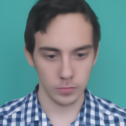

(126, 126, 3)



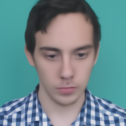

(126, 126, 3)



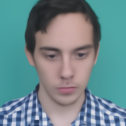

(128, 126, 126, 3)
Inference time:0:00:06.311259
torch.Size([1, 128])
tensor([[-5.4668e+00, -4.6028e+00, -2.8771e+00, -5.9036e-01, -8.1965e-01,
         -2.0265e+00, -2.8564e+00, -3.3355e+00, -3.1664e+00, -1.3783e+00,
          3.9703e-01,  2.2317e-01, -2.2447e+00, -2.5972e+00, -1.2981e+00,
         -9.3178e-01, -3.0227e+00, -4.2657e+00, -4.4820e+00, -3.4815e+00,
         -1.8964e+00, -1.1030e+00, -1.8220e+00, -3.1478e+00, -3.9533e+00,
         -4.4620e+00, -4.6998e+00, -4.0024e+00, -3.2273e+00, -2.5900e+00,
         -2.3329e+00, -1.3617e+00,  6.7790e-03,  8.8018e-01, -9.8101e-02,
         -5.5148e-01,  4.3795e-01, -3.0656e-01, -3.1020e+00, -5.1189e+00,
         -5.6364e+00, -4.9979e+00, -3.6504e+00, -2.7871e+00, -3.4244e+00,
         -4.1703e+00, -3.8095e+00, -2.5679e+00, -4.8134e-01,  7.6848e-01,
          1.4677e+00,  1.6169e+00,  8.0753e-01, -8.1568e-01, -2.7098e+00,
         -4.0088e+00, -4.6649e+00, -3.4655e+00, -2.3182e+00, -2.0689e+00,
         -3.1547e+00, -4.0111e+00, -4.1120

In [ ]:
# SwinPhys model inference
start = datetime.datetime.now()
print(start)
swinphys_restore_model = SwinPhys(swinir_model_path=MODEL_PATH_40, physnet_model_path=PHYSNET_MODEL_PATH, window_size=7, img_size=IMAGE_SIZE, num_frames=128)
rPPG_restore, _, _, _ =  swinphys_restore_model(preprocessed_frames)
print("Inference time:" + str(datetime.datetime.now() - start))
print(rPPG_restore.shape)
print(rPPG_restore)

swinphys_model = SwinPhys(swinir_model_path=MODEL_PATH_40, physnet_model_path=PHYSNET_MODEL_PATH, restore=False, window_size=7, img_size=IMAGE_SIZE, num_frames=NUM_FRAMES)
rPPG, _, _, _ =  swinphys_model(np.array(preprocessed_frames))

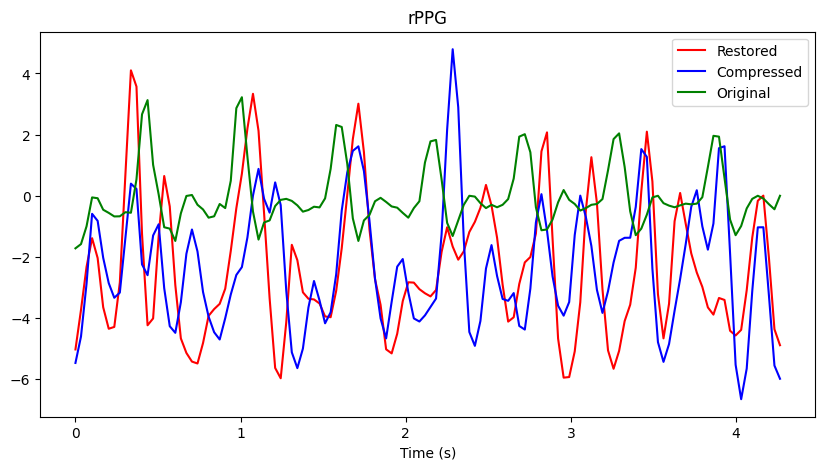

In [ ]:
def diff_normalize_label(label):
  """Calculate discrete difference in labels along the time-axis and normalize by its standard deviation."""
  diff_label = np.diff(label, axis=0)
  diffnormalized_label = diff_label / np.std(diff_label)
  diffnormalized_label = np.append(diffnormalized_label, np.zeros(1), axis=0)
  diffnormalized_label[np.isnan(diffnormalized_label)] = 0
  return diffnormalized_label

fs = 30 # Video Frame Rate
samples = NUM_FRAMES
x_time = np.linspace(0, samples/fs, num=samples)
compressed = np.array(rPPG_restore[0].cpu().detach())
restored = np.array(rPPG[0].cpu().detach())
diff_normalized_label = diff_normalize_label(bvp[:samples])

plt.figure(figsize=(10,5))
plt.title('rPPG')
plt.xlabel('Time (s)')
plt.plot(x_time, restored, color='r')
plt.plot(x_time, compressed, color='b')
plt.plot(x_time, diff_normalized_label, color='g')
plt.legend(['Restored', 'Compressed', 'Original'])